# Black Lives Matter: Topic Modeling

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/opardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

In [5]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'amp'])

## Import data

In [9]:
df = pd.read_csv('Data/tw1.csv')
data = df['full_text'].values.tolist()

/Users/opardo/anaconda3/envs/CAP/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,5,7,8,9,15,16,18,19,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pre-processing tweets

### Unique tweets

Many tweets are repeated or empty. The reason behind can be that they are written by bots, and spread telling the same message. 

In [10]:
original_num = len(data)
print('The total number of tweets is %d.' % (original_num))

The total number of tweets is 293245.


In [11]:
# Get unique tweets
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
unique_num = len(data)
unique_perc = round(100.0 * unique_num  / original_num)
print('However, the number of unique tweets is %d. That means %d out of 100 of the original ones.' % (unique_num, unique_perc))

However, the number of unique tweets is 83498. That means 28 out of 100 of the original ones.


In addition, there are some tweets of the form _RT @PaulPannone: Bridge March over Troubled Water http://t.co/Sh5ToZy6PF #AlSharpton #StatenIsland #EricGarner #Verrazano'_.

Therefore, we would like to remove the _RT @PaulPannone:_ part and keep the original text

_Bridge March over Troubled Water http://t.co/Sh5ToZy6PF #AlSharpton #StatenIsland #EricGarner #Verrazano'_

which might be already considered in a different tweet.

In [12]:
# Remove RT @name:
data = [re.sub("^RT @\S*\s?", "", sent) for sent in data]
data = [re.sub('^"@\S*\s?', "", sent) for sent in data]
data = [re.sub('^“@\S*\s?', "", sent) for sent in data]
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
unique_rt_num = len(data)
unique_rt_perc = round(100.0 * unique_rt_num  / original_num)
print('In consequence, the number of tweets declines to %d. That means %d out of 100 of the original ones.' % (unique_rt_num, unique_rt_perc))

In consequence, the number of tweets declines to 73621. That means 25 out of 100 of the original ones.


### URLs

A lot of tweets include links to other websites, for instance, news and articles. This _URLs_ cannot be considered words and is hard to know where are they pointing, because the text that appears is usually an encrypted version. However, just the fact that the tweet includes a link can be useful for our analysis. Therefore, we will replace any URL with the _http_ word. 

That means that 

_Bridge March over Troubled Water http://t.co/Sh5ToZy6PF #AlSharpton #StatenIsland #EricGarner #Verrazano_ 

now becomes 

_Bridge March over Troubled Water http #AlSharpton #StatenIsland #EricGarner #Verrazano_.

In [13]:
# Remove URLs
data = [re.sub("\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*", "http", sent) for sent in data]
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
unique_http_num = len(data)
unique_http_perc = round(100.0 * unique_http_num  / original_num)
print('Accordingly, the number of tweets now reduces to %d. That means %d out of 100 of the original ones.' % (unique_http_num, unique_http_perc))

Accordingly, the number of tweets now reduces to 64105. That means 22 out of 100 of the original ones.


### Remove new lines _\n_

The are some tweets where the user typed _Enter_ to start a new line. This is translated into the _\n_ character, which can create confusion when we are separating words. Consequently, we will replace those characters with ' '.

In [14]:
data = [re.sub("\n", " ", sent) for sent in data]
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
len(data)

64075

### Decompose into bag of words

Let's take a tweet in our data:

In [15]:
tweet = 'News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'man', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [17]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'man', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'man', 'shot', 'video', 'eric_garner', 'apparent_choke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [21]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'man', 'shoot', 'video', 'eric_garner', 'apparent_choke', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(12, 1), (56, 1), (64, 1), (216, 1), (389, 1), (435, 1), (522, 1), (605, 1), (2854, 1), (4363, 1)]


In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('hold', 1),
  ('eric_garner', 1),
  ('shoot', 1),
  ('arrest', 1),
  ('man', 1),
  ('video', 1),
  ('charge', 1),
  ('news', 1),
  ('apparent_choke', 1),
  ('firearm', 1)]]

### LDA Mallet Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

In [24]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

This will give us 10 different topics (a fixed parameter we used). Now, we are going to explore the 10 words most representative of each of these topics. 

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('http', 0.23276428102429417),
   ('man', 0.07124097176625083),
   ('murder', 0.05991464215364412),
   ('ericgarner', 0.05808847669074196),
   ('arrest', 0.038698292843072885),
   ('video', 0.03237852921864741),
   ('film', 0.01690741956664478),
   ('hold', 0.009684832567301379),
   ('guy', 0.009582239001969797),
   ('wife', 0.008186966513460276)]),
 (1,
  [('ferguson', 0.19323787751173144),
   ('rt', 0.09391168331127421),
   ('http', 0.08613083062607789),
   ('protest', 0.029258412545622267),
   ('antoniofrench', 0.02825572534392171),
   ('read', 0.020494926402759395),
   ('break', 0.018670035695664382),
   ('fire', 0.014177997032045883),
   ('mo', 0.014077728311875827),
   ('tonight', 0.013075041110175269)]),
 (2,
  [('mikebrown', 0.1360604355862734),
   ('happen', 0.036024270674274696),
   ('make', 0.02923330386562726),
   ('fuck', 0.024592140159125614),
   ('shit', 0.0226231616169734),
   ('thing', 0.021116290283693644),
   ('hear', 0.016756409226070884),
   ('good', 0.0141

Finally, we will obtain the coherence score, a metric that will indicate how good the model fit is.

In [26]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.41034813745967796


### Choosing the number of topics

As we mentioned before, the number of topics was fixed to 10. However, we would like to optimize that hyper-parameter as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed = 2019)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

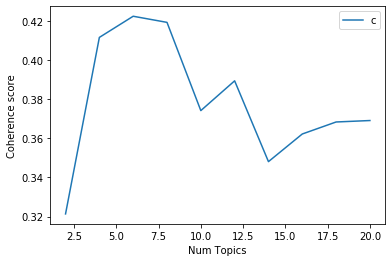

In [29]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3214
Num Topics = 4  has Coherence Value of 0.4115
Num Topics = 6  has Coherence Value of 0.4223
Num Topics = 8  has Coherence Value of 0.4192
Num Topics = 10  has Coherence Value of 0.3741
Num Topics = 12  has Coherence Value of 0.3893
Num Topics = 14  has Coherence Value of 0.3481
Num Topics = 16  has Coherence Value of 0.3622
Num Topics = 18  has Coherence Value of 0.3683
Num Topics = 20  has Coherence Value of 0.369


### Working with the optimal model

The model we liked the most was the one with 8 topics. Although the 4-theme model has the best performance, the 8-theme balances the diversity of topics with acceptable performance.

In [31]:
optimal_model = model_list[3]

In [32]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False))

[(0,
  [('black', 0.0690938848863144),
   ('people', 0.05476484652043453),
   ('mikebrown', 0.024566358049453636),
   ('happen', 0.023876381957927503),
   ('white', 0.021806453683349113),
   ('riot', 0.020314179810978644),
   ('ferguson', 0.01720126442130261),
   ('thing', 0.01691243722019865),
   ('live', 0.016495242374159592),
   ('call', 0.016190369217438744)]),
 (1,
  [('mikebrown', 0.08317006584229966),
   ('murder', 0.046892564637867354),
   ('story', 0.030480167014613778),
   ('make', 0.023317809539103902),
   ('sad', 0.020025694555965954),
   ('fuck', 0.01997751726352979),
   ('shit', 0.01809860285851935),
   ('stop', 0.01753653444676409),
   ('read', 0.016412397623253572),
   ('situation', 0.012718805203147584)]),
 (2,
  [('http', 0.1321124822508161),
   ('eric_garner', 0.09632134440004099),
   ('death', 0.07837454071699383),
   ('ericgarner', 0.05545064628987162),
   ('man', 0.0508248795983195),
   ('chokehold', 0.044471769648529565),
   ('nypd', 0.04283225740342248),
   ('ar

## Exploring the results

### Dominant topic in each sentence

In [33]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [34]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1368,"mikebrown, justice, family, peace, pray, violence, tonight, day, hope, friend",MORE Malcolm...LESS Martin! #MichaelBrown
1,1,1.0,0.1410,"mikebrown, murder, story, make, sad, fuck, shit, stop, read, situation",#MikeBrown ran away for a reason and now you know why
2,2,0.0,0.1727,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",Sad. So unsurprised at what is unfolding. Angry. Holding hearts in solidarity. Here to stand and and work. #Ferguson #M…
3,3,6.0,0.1653,"brown, mike, shoot, michael, unarmed, time, rip, teen, police, shooting","But as soon as she opened her mouth about Mike Brown's murder, twitter IMMEDIATELY escorted her to a stadium of seats. Lol I love y'all."
4,4,3.0,0.2099,"ferguson, news, loot, stl, report, medium, watch, show, quicktrip, find","Find it interesting news outlets were not labeling those white thieves in Boston as ""Looters"" #Ferguson #MikeBrown http"
5,5,6.0,0.1447,"brown, mike, shoot, michael, unarmed, time, rip, teen, police, shooting",I don't see anything wrong with the picture they chose of Mike Brown. Perhaps bc I don't think what one wears = deserv…
6,6,2.0,0.2052,"http, eric_garner, death, ericgarner, man, chokehold, nypd, arrest, ruled_homicide, video","!RT @NYDailyNews: BREAKING: Eric Garner's death ruled a homicide. http Cause of death:""chokehold."" h…"
7,7,2.0,0.1731,"http, eric_garner, death, ericgarner, man, chokehold, nypd, arrest, ruled_homicide, video",Coroner rules that police chokehold killed Eric Garner http
8,8,7.0,0.1813,"police, kill, cop, officer, michaelbrown, gun, put, shot, car, leave",@barrybateman Struggle for the gun? But why did the policeman shoot #MichaelBrown 10 times? Something doesn't add up with #AmericanCops ...
9,9,6.0,0.1844,"brown, mike, shoot, michael, unarmed, time, rip, teen, police, shooting","I don't care what reasons are claimed. Shooting an unarmed teen 10 times is not defense, it's murder #MikeBrown #Ferguson"""


### Most representative tweets

In [35]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3164,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",black lives matter. black lives matter. black lives matter. black lives matter. black lives matter. black lives matter. black lives matter.
1,0.0,0.3164,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",BLACK LIFE MATTERS. BLACK LIVES MATTER. BLACK LIFE MATTERS. BLACK LIVES MATTER. BLACK LIFE MATTERS. BLACK LIVES MATTER. Ad infinitum.
2,0.0,0.3056,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",black lives matter. black lives matter. black lives matter. black lives matter. black lives matter. black lives matter. black…
3,0.0,0.2996,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",Bitch “@mamacitamusings: BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MAT
4,0.0,0.2944,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",BLACK LIFE MATTERS. BLACK LIVES MATTER. BLACK LIFE MATTERS. BLACK LIVES MATTER. BLACK LIFE MATTERS. BLACK LIVES MATTER.…
5,0.0,0.2944,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER. BLACK LIVES MATTER.
6,0.0,0.2799,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call","RT @bwahby: ""Returning hate for hate multiplies hate, adding deeper darkness to a night already devoid of stars."" Dr MLK #…"
7,0.0,0.2720,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call","""Returning hate for hate multiplies hate, adding deeper darkness to a night already devoid of stars."" Dr MLK #Ferguson"
8,0.0,0.2703,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call","""Returning hate for hate multiplies hate, adding deeper darkness to a night already devoid of stars."" - Dr. Martin Luther Ki…"
9,0.0,0.2664,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",Black lives matter. Black children matter. Black children are not adults. They are children. Black people are not di…


### Topic Distribution

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"black, people, mikebrown, happen, white, riot, ferguson, thing, live, call",8227,0.1284
1.0,1.0,"mikebrown, murder, story, make, sad, fuck, shit, stop, read, situation",8114,0.1266
2.0,2.0,"http, eric_garner, death, ericgarner, man, chokehold, nypd, arrest, ruled_homicide, video",9791,0.1528
3.0,3.0,"ferguson, news, loot, stl, report, medium, watch, show, quicktrip, find",8029,0.1253
4.0,4.0,"mikebrown, justice, family, peace, pray, violence, tonight, day, hope, friend",7836,0.1223
5.0,5.0,"http, ferguson, rt, protest, antoniofrench, hand, back, break, follow, fire",6801,0.1061
6.0,6.0,"brown, mike, shoot, michael, unarmed, time, rip, teen, police, shooting",9349,0.1459
7.0,7.0,"police, kill, cop, officer, michaelbrown, gun, put, shot, car, leave",5928,0.0925
